# **DATASET**
The dataset used for this project consists of features extracted from both phishing and legitimate URLs, providing a rich source of data for classification tasks. The features include characteristics such as URL length, the presence of certain keywords, the number of subdomains, and other structural elements that can distinguish phishing sites from legitimate ones. The dataset is well-suited for machine learning applications and will be used to train and evaluate multiple models, including Logistic Regression (LR), Random Forest, Gradient Boosting, Support Vector Machines (SVM), and Neural Networks. By leveraging these models, the project aims to achieve accurate detection of phishing URLs with a focus on improving the robustness and interpretability of the classification process, analyzing feature importance to gain insights into the most significant factors driving the classification.

As of today, the dataset originally sourced from Kaggle was removed: https://www.kaggle.com/datasets/sergioagudelo/phishing-url-detection

# **IMPORTS**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Scikit-learn imports
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, classification_report, precision_recall_curve
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression

# Suppress warnings
warnings.simplefilter("ignore", ConvergenceWarning)
warnings.filterwarnings('ignore')

# **RETRIEVING DATA**

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# Read the CSV in chunks
chunksize = 100000
#chunks = pd.read_csv('/content/drive/MyDrive/ds3000/Project/ds3000_group25/Dataset_Group25.csv', chunksize=chunksize)
chunks = pd.read_csv('Dataset_Group25.csv', chunksize=chunksize)

# Process each chunk
df_list = []
for chunk in chunks:
    df_list.append(chunk)

# Combine all chunks back into a single dataframe
data = pd.concat(df_list, ignore_index=True)
original_data = data.copy()

In [5]:
data = original_data.copy()

In [6]:
data.head()

,url,source,label,url_length,starts_with_ip,url_entropy,has_punycode,digit_letter_ratio,dot_count,at_count,dash_count,tld_count,domain_has_digits,subdomain_count,nan_char_entropy,has_internal_links,whois_data,domain_age_days
0,apaceast.cloudguest.central.arubanetworks.com,Cisco-Umbrella,legitimate,45,False,3.924535,False,0.0,4,0,0,0,False,3,0.310387,False,"{'domain_name': ['ARUBANETWORKS.COM', 'arubane...",8250.0
1,quintadonoval.com,Majestic,legitimate,17,False,3.572469,False,0.0,1,0,0,0,False,0,0.240439,False,"{'domain_name': ['QUINTADONOVAL.COM', 'quintad...",10106.0
2,nomadfactory.com,Majestic,legitimate,16,False,3.327820,False,0.0,1,0,0,0,False,0,0.250000,False,"{'domain_name': ['NOMADFACTORY.COM', 'nomadfac...",8111.0
3,tvarenasport.com,Majestic,legitimate,16,False,3.500000,False,0.0,1,0,0,0,False,0,0.250000,False,"{'domain_name': ['TVARENASPORT.COM', 'tvarenas...",5542.0
4,widget.cluster.groovehq.com,Cisco-Umbrella,legitimate,27,False,3.930270,False,0.0,3,0,0,0,False,2,0.352214,False,"{'domain_name': 'GROOVEHQ.COM', 'registrar': '...",5098.0


# **DATA PREPROCESSING**

In [7]:
# Drop rows with missing 'url' or 'digit_letter_ratio'
data = data.dropna(subset=['url', 'digit_letter_ratio'])

# Impute `domain_age_days` missing values with 0
data.loc[:, 'domain_age_days'] = data['domain_age_days'].fillna(0)

# Create a binary indicator for `domain_age_days` (1 if > 0, 0 if 0)
data = data.assign(has_domain_age=(data['domain_age_days'] > 0).astype(int))

# Drop the original `domain_age_days` column
data = data.drop(columns=['domain_age_days'])

# Impute `whois_data` with a binary indicator (1 if not null, 0 if null)
data['has_whois_data'] = data['whois_data'].notnull().astype(int)

# Drop the original `whois_data` column
data = data.drop(columns=['whois_data'])

# Encode the 'label' column as numerical values: 0 for 'legitimate' and 1 for 'phishing'
data['label'] = data['label'].map({'legitimate': 0, 'phishing': 1}).astype(int)

# Convert boolean values to numerical representations (0 for False, 1 for True)
boolean_cols = ['starts_with_ip', 'has_internal_links', 'domain_has_digits', 'has_punycode']  # Add actual column names
for col in boolean_cols:
    if col in data.columns:
        data[col] = data[col].astype(bool).astype(int)

# Drop the 'url' and 'source' columns, as all relevant information has already been extracted from the URL and phishing sources are inherently captured in other features.
data = data.drop(columns=['url', 'source'])

# Standardize the numerical columns
numerical_cols = ['url_length','url_entropy','digit_letter_ratio','dot_count','at_count','dash_count','tld_count','subdomain_count','nan_char_entropy']
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Display updated dataframe
data.head()

,label,url_length,starts_with_ip,url_entropy,has_punycode,digit_letter_ratio,dot_count,at_count,dash_count,tld_count,domain_has_digits,subdomain_count,nan_char_entropy,has_internal_links,has_domain_age,has_whois_data
0,0,-0.011818,0,0.026038,0,-0.476685,1.051278,-0.081131,-0.445691,-0.100466,0,2.014307,-0.823254,0,1,1
1,0,-0.389422,0,-0.527771,0,-0.476685,-0.676455,-0.081131,-0.445691,-0.100466,0,-0.704914,-1.195313,0,1,1
2,0,-0.402908,0,-0.912613,0,-0.476685,-0.676455,-0.081131,-0.445691,-0.100466,0,-0.704914,-1.144457,0,1,1
3,0,-0.402908,0,-0.641768,0,-0.476685,-0.676455,-0.081131,-0.445691,-0.100466,0,-0.704914,-1.144457,0,1,1
4,0,-0.254563,0,0.035060,0,-0.476685,0.475367,-0.081131,-0.445691,-0.100466,0,1.107900,-0.600772,0,1,1


In [8]:
data.isnull().sum()

label                 0
url_length            0
starts_with_ip        0
url_entropy           0
has_punycode          0
digit_letter_ratio    0
dot_count             0
at_count              0
dash_count            0
tld_count             0
domain_has_digits     0
subdomain_count       0
nan_char_entropy      0
has_internal_links    0
has_domain_age        0
has_whois_data        0
dtype: int64

In [9]:
data.describe()

,label,url_length,starts_with_ip,url_entropy,has_punycode,digit_letter_ratio,dot_count,at_count,dash_count,tld_count,domain_has_digits,subdomain_count,nan_char_entropy,has_internal_links,has_domain_age,has_whois_data
count,2499999.0,2.499999e+06,2.499999e+06,2.499999e+06,2.499999e+06,2.499999e+06,2.499999e+06,2.499999e+06,2.499999e+06,2.499999e+06,2.499999e+06,2.499999e+06,2.499999e+06,2.499999e+06,2.499999e+06,2.499999e+06
mean,0.5,7.462407e-17,1.068720e-02,2.331763e-15,8.432003e-04,2.920616e-16,1.021363e-16,-7.722750e-17,1.580248e-18,-6.899089e-17,1.093976e-01,-1.315357e-17,4.278265e-16,2.374321e-02,6.993059e-01,7.818803e-01
std,0.5,1.000000e+00,1.028251e-01,1.000000e+00,2.902567e-02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.121375e-01,1.000000e+00,1.000000e+00,1.522481e-01,4.585600e-01,4.129692e-01
min,0.0,-5.647380e-01,0.000000e+00,-5.988752e+00,0.000000e+00,-4.766846e-01,-1.252366e+00,-8.113062e-02,-4.456909e-01,-1.004657e-01,0.000000e+00,-7.049138e-01,-2.384533e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.0,-3.894219e-01,0.000000e+00,-7.159842e-01,0.000000e+00,-4.766846e-01,-6.764554e-01,-8.113062e-02,-4.456909e-01,-1.004657e-01,0.000000e+00,-7.049138e-01,-8.444782e-01,0.000000e+00,0.000000e+00,1.000000e+00
50%,0.0,-2.275917e-01,0.000000e+00,6.099396e-03,0.000000e+00,-4.766846e-01,-1.005442e-01,-8.113062e-02,-4.456909e-01,-1.004657e-01,0.000000e+00,2.014933e-01,-2.644019e-01,0.000000e+00,1.000000e+00,1.000000e+00
75%,1.0,8.258285e-02,0.000000e+00,6.627184e-01,0.000000e+00,6.721179e-02,4.753669e-01,-8.113062e-02,1.557372e-01,-1.004657e-01,0.000000e+00,2.014933e-01,8.154623e-01,0.000000e+00,1.000000e+00,1.000000e+00
max,1.0,3.435807e+02,1.000000e+00,3.367539e+00,1.000000e+00,8.453432e+01,1.202649e+02,2.272869e+02,1.932142e+02,1.663488e+02,1.000000e+00,3.827059e+01,7.640039e+00,1.000000e+00,1.000000e+00,1.000000e+00


# **EXPLORATORY DATA ANALYSIS (EDA)**

In [10]:
# Define the predictor variables and the outcome variable
X = data.drop(columns=['label'])  # All features except the target
y = data['label']  # Response variable

# Split the data into train and test sets (20% holdout for test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Check the shapes of the resulting datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (1999999, 15) (1999999,)
Testing set shape: (500000, 15) (500000,)


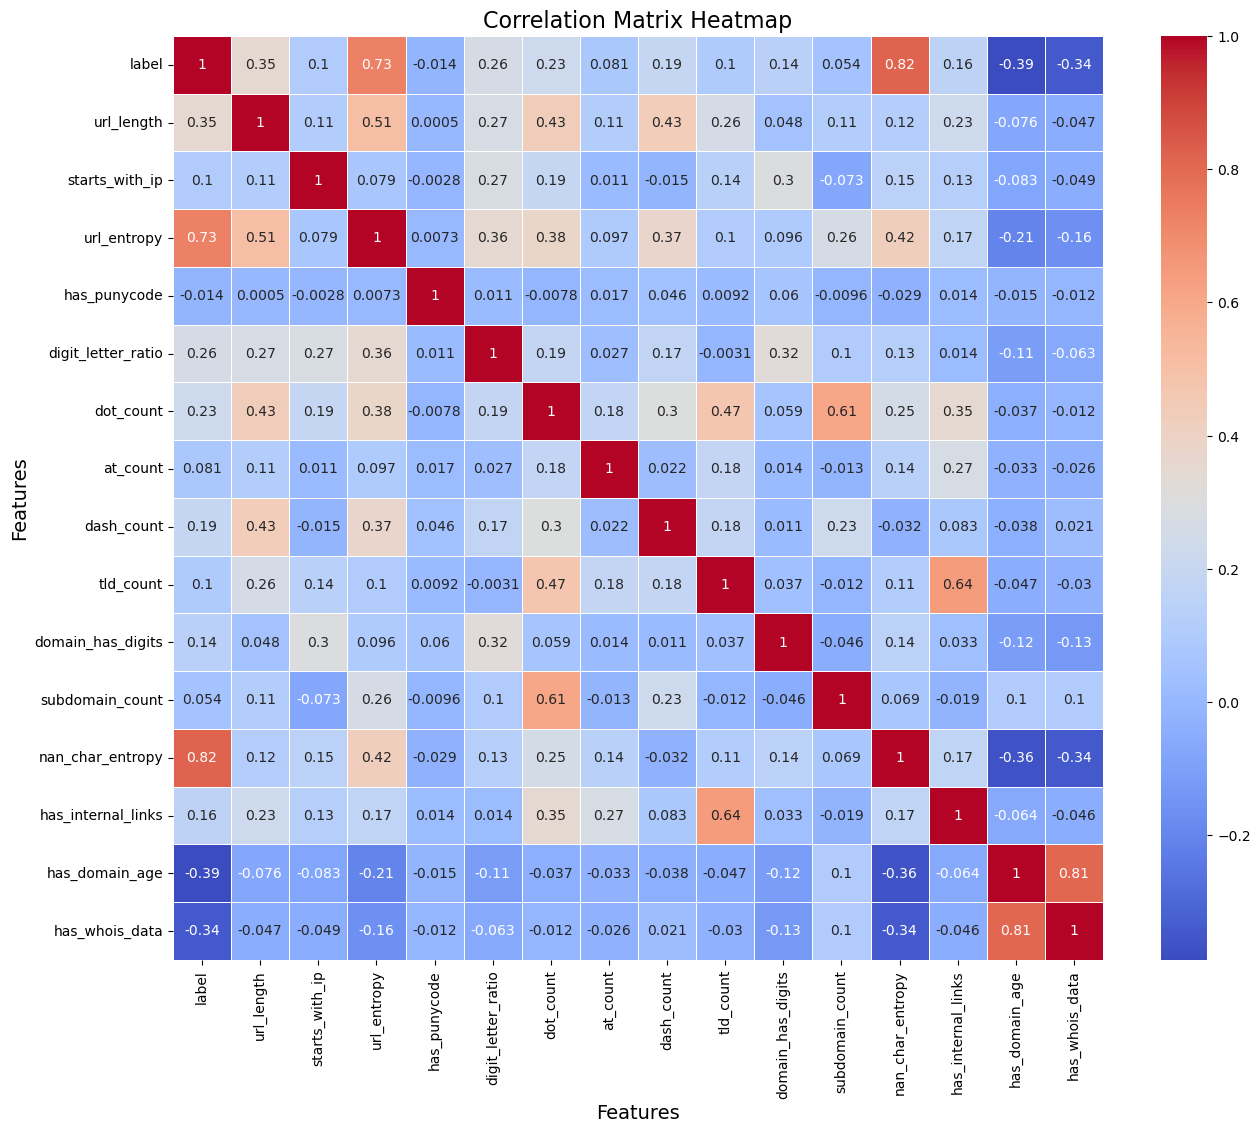

In [11]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(15, 12))

# Draw a heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Add labels and a title
plt.title("Correlation Matrix Heatmap", fontsize=16)  # Title for the heatmap
plt.xlabel("Features", fontsize=14)  # Label for the x-axis
plt.ylabel("Features", fontsize=14)  # Label for the y-axis

# Show the plot
plt.show()

# **UTILITY METHODS**

In [13]:
# Plot logistic regression scatter
def plot_scatter(model, X_test, y_test, sample_size=1000):
    # Predict the classes and probabilities
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Randomly sample a subset of the data to avoid overcrowding
    if len(X_test) > sample_size:
        sample_indices = np.random.choice(len(X_test), sample_size, replace=False)
        X_test_sample = X_test.iloc[sample_indices]  # Use .iloc to select rows based on indices
        y_test_sample = y_test.iloc[sample_indices]  # Same for y_test
        y_pred_sample = y_pred[sample_indices]
        y_pred_proba_sample = y_pred_proba[sample_indices]
    else:
        X_test_sample = X_test
        y_test_sample = y_test
        y_pred_sample = y_pred
        y_pred_proba_sample = y_pred_proba

    # Create a scatter plot for predicted probabilities
    plt.figure(figsize=(9, 4.5))
    plt.scatter(range(len(y_test_sample)), y_test_sample, alpha=0.5, label='Actual Outcomes', color='blue', s=15, marker='o')
    plt.scatter(range(len(y_pred_sample)), y_pred_sample, alpha=0.5, label='Predicted Outcomes', color='orange', s=15, marker='x')
    plt.scatter(range(len(y_pred_proba_sample)), y_pred_proba_sample, alpha=0.25, label='Predicted Probabilities', color='green', s=15, marker='^')

    plt.grid(True, linestyle='-', alpha=0.7)
    plt.title(model.__class__.__name__+' Predictions vs Actual Outcomes', fontsize=16)
    plt.xlabel('Sample Index', fontsize=14)
    plt.ylabel('Prediction (0 or 1)', fontsize=14)
    plt.legend(loc='upper right', fontsize=12)
    plt.tight_layout()  # Ensure consistent plot sizing
    plt.show()

    return y_pred

# Print classification metrics
def print_classification_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    print("Confusion Matrix:")
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    # Plot confusion matrix heatmap
    confusion_matrix_heatmap(y_test, y_pred)
    print("\nMetrics:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

# Plot confusion matrix heatmap
def confusion_matrix_heatmap(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(9, 4.5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title('Confusion Matrix Heatmap', fontsize=16)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.tight_layout()  # Ensure consistent plot sizing
    plt.show()

# Plot feature importance
def plot_feature_importance(model, feature_names):
    if hasattr(model, 'coef_'):  # For models like Logistic Regression
        coefficients = model.coef_.flatten()
        feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
        feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
        feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

        plt.figure(figsize=(9, 4.5))
        sns.barplot(x='Abs_Coefficient', y='Feature', data=feature_importance)
        plt.title("Feature Importance (Absolute Coefficients)", fontsize=16)
        plt.xlabel("Absolute Coefficient Value", fontsize=14)
        plt.ylabel("Feature Name", fontsize=14)
        plt.tight_layout()  # Ensure consistent plot sizing
        plt.show()

        print("\nTop Features by Importance:")
        print(feature_importance.head(10))
    elif hasattr(model, 'feature_importances_'):  # For RandomForestClassifier
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': model.feature_importances_
        }).sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(9, 4.5))
        sns.barplot(x='Importance', y='Feature', data=feature_importance)
        plt.title("Feature Importance", fontsize=16)
        plt.xlabel("Importance Value", fontsize=14)
        plt.ylabel("Feature Name", fontsize=14)
        plt.tight_layout()  # Ensure consistent plot sizing
        plt.show()

        print("\nTop Features by Importance:")
        print(feature_importance.head(10))


# Plot AUROC curve
def plot_auroc_curve(model, X_test, y_test):
    # Get the predicted probabilities for the positive class
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(9, 4.5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUROC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
    plt.xlabel('False Positive Rate (FPR)', fontsize=14)
    plt.ylabel('True Positive Rate (TPR)', fontsize=14)
    plt.legend(loc='lower right', fontsize=12)
    plt.tight_layout()  # Ensure consistent plot sizing
    plt.show()

# Evaluate the best model
def evaluate_best_model(best_model, X_test, y_test, feature_names):
    print("Evaluating the Best Model:")
    print("=" * 50)

    # Plot predictions vs outcomes
    y_pred = plot_scatter(best_model, X_test, y_test)

    # Print classification metrics
    print_classification_metrics(y_test, y_pred)

    # Plot feature importance
    plot_feature_importance(best_model, feature_names)

    # Plot AUROC curve
    plot_auroc_curve(best_model, X_test, y_test)

# **LOGISTIC REGRESSION**

In [2]:
# --------------------------- Hyperparameter Tuning --------------------------- #
# Define the model
model = LogisticRegression(solver='saga', max_iter=15, class_weight='balanced')

# Define the parameter grid with conditional inclusion of 'l1_ratio'
param_grid = [
    {
        'penalty': ['l1', 'l2'],
        'C': [0.1, 1, 10]
    },
    {
        'penalty': ['elasticnet'],
        'C': [0.1, 1, 10],
        'l1_ratio': [0.2, 0.5, 0.8]
    }
]

# Perform grid search with 5 Stratified k-fold
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='recall', n_jobs=-1, verbose=1)

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Cross-Validated Recall:", grid_search.best_score_)

NameError: name 'LogisticRegression' is not defined

Test Set Recall: 0.9992802763738724
Evaluating the Best Model:


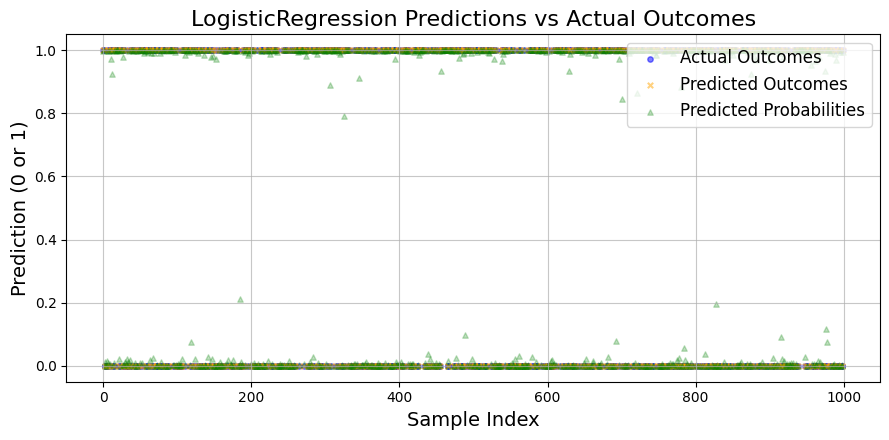

Confusion Matrix:
TN: 249902, FP: 2, FN: 180, TP: 249916


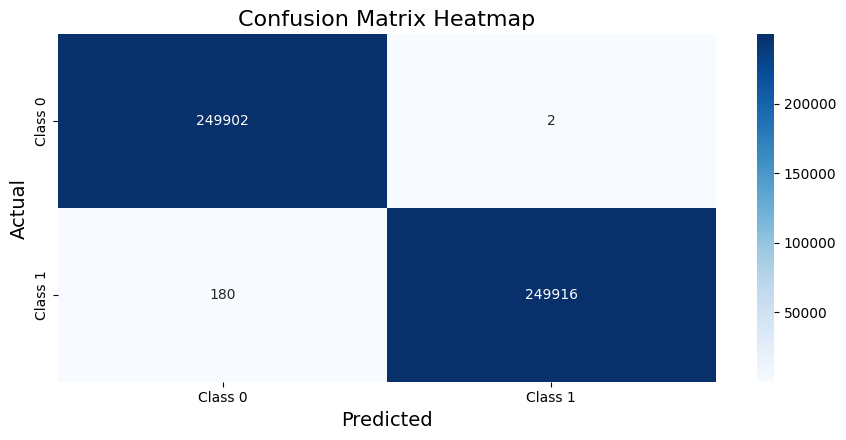


Metrics:
Accuracy: 0.9996
Precision: 1.0000
Recall: 0.9993
F1 Score: 0.9996

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00    249904
     Class 1       1.00      1.00      1.00    250096

    accuracy                           1.00    500000
   macro avg       1.00      1.00      1.00    500000
weighted avg       1.00      1.00      1.00    500000



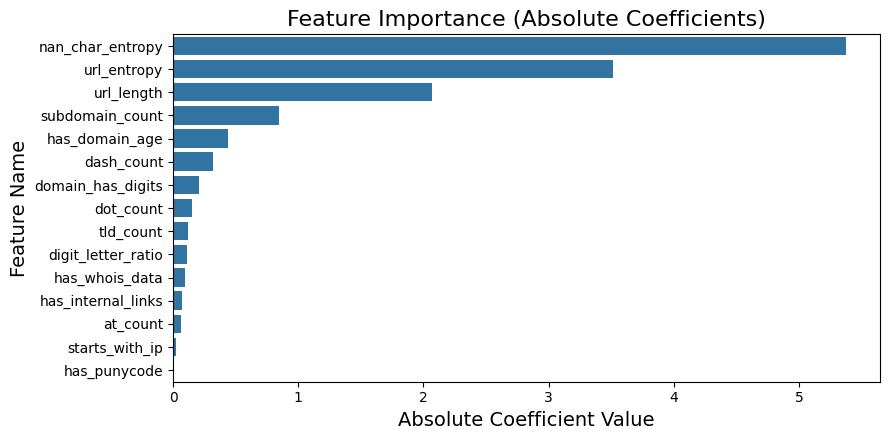


Top Features by Importance:
               Feature  Coefficient  Abs_Coefficient
11    nan_char_entropy     5.377359         5.377359
2          url_entropy     3.514239         3.514239
0           url_length     2.066167         2.066167
10     subdomain_count    -0.845745         0.845745
13      has_domain_age    -0.435353         0.435353
7           dash_count     0.316513         0.316513
9    domain_has_digits     0.207802         0.207802
5            dot_count    -0.155165         0.155165
8            tld_count     0.117880         0.117880
4   digit_letter_ratio     0.113913         0.113913


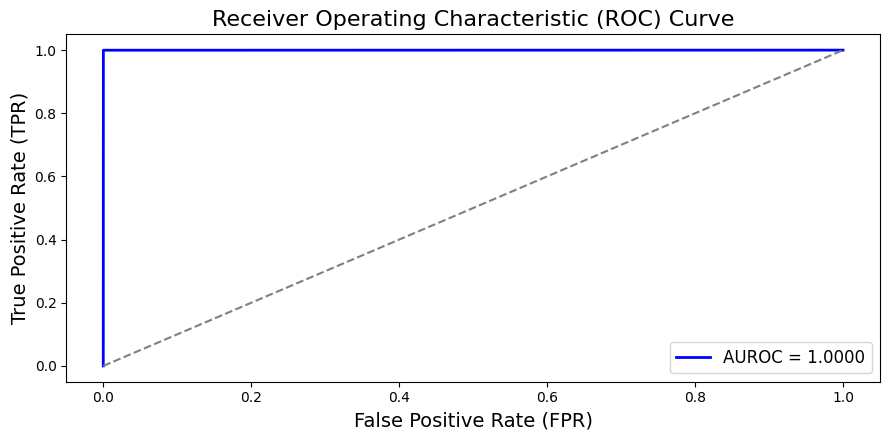

In [12]:
# --------------------------- Best Model Fitting & Evaluation --------------------------- #
# Predicting on the test set
y_pred_test = best_model.predict(X_test)

# Calculate recall on the test set
test_score = recall_score(y_test, y_pred_test)
print("Test Set Recall:", test_score)

# Get feature names for plotting
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]

# Now evaluate the best model using the function you provided
evaluate_best_model(best_model, X_test, y_test, feature_names)

# **RANDOM FOREST**

In [17]:
# --------------------------- Hyperparameter Tuning --------------------------- #
# Define the Random Forest model
model = RandomForestClassifier(class_weight='balanced', random_state=0)

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [5, 10],  # Number of trees
    'max_depth': [5,10],   # Max depth of trees
    'min_samples_split': [2, 5],   # Min samples required to split an internal node
    'min_samples_leaf': [1, 2],     # Min samples required at a leaf node
    'max_features': ['sqrt','log2'],  # Number of features to consider at each split
}

# Perform grid search with Stratified k-fold
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='recall', n_jobs=-1, verbose=1)

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Output the best hyperparameters and cross-validated recall score
print("Best Parameters:", best_params)
print("Best Cross-Validated Recall:", grid_search.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
Best Cross-Validated Recall: 0.999950995264542


Test Set Recall: 0.9999560168895144
Evaluating the Best Model:


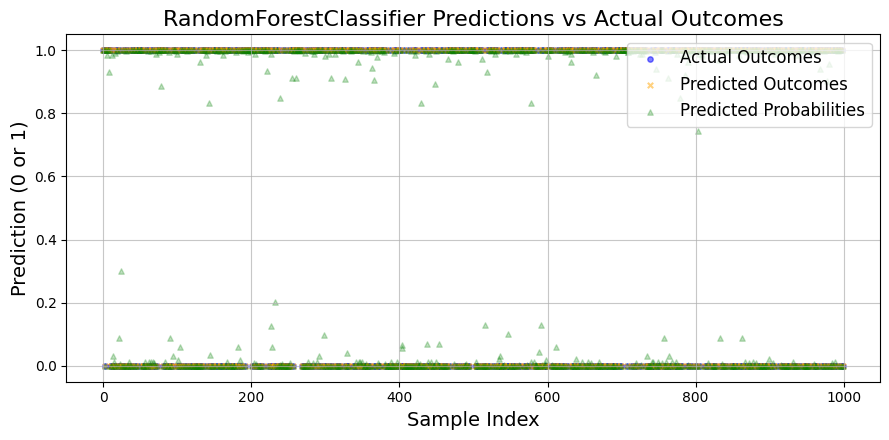

Confusion Matrix:
TN: 249890, FP: 14, FN: 11, TP: 250085


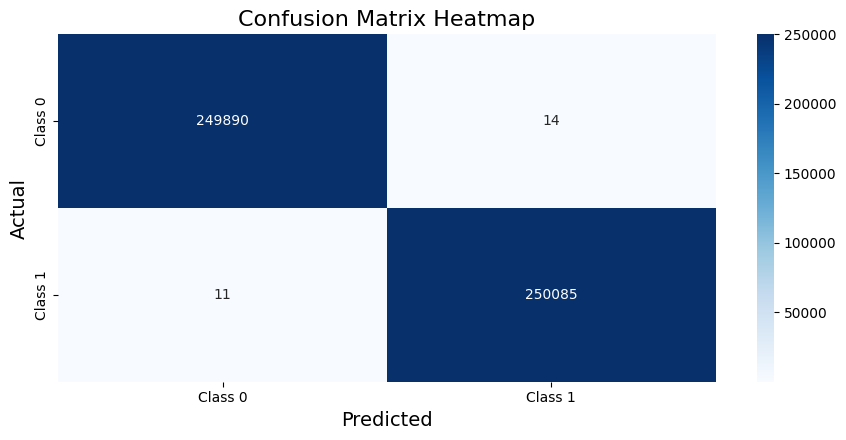


Metrics:
Accuracy: 1.0000
Precision: 0.9999
Recall: 1.0000
F1 Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00    249904
     Class 1       1.00      1.00      1.00    250096

    accuracy                           1.00    500000
   macro avg       1.00      1.00      1.00    500000
weighted avg       1.00      1.00      1.00    500000



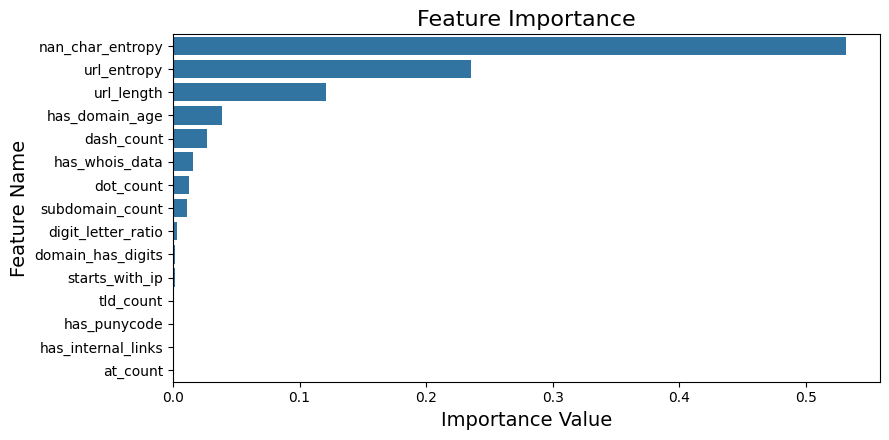


Top Features by Importance:
               Feature  Importance
11    nan_char_entropy    0.532155
2          url_entropy    0.235464
0           url_length    0.121297
13      has_domain_age    0.038502
7           dash_count    0.026736
14      has_whois_data    0.016170
5            dot_count    0.012731
10     subdomain_count    0.010729
4   digit_letter_ratio    0.002848
9    domain_has_digits    0.001361


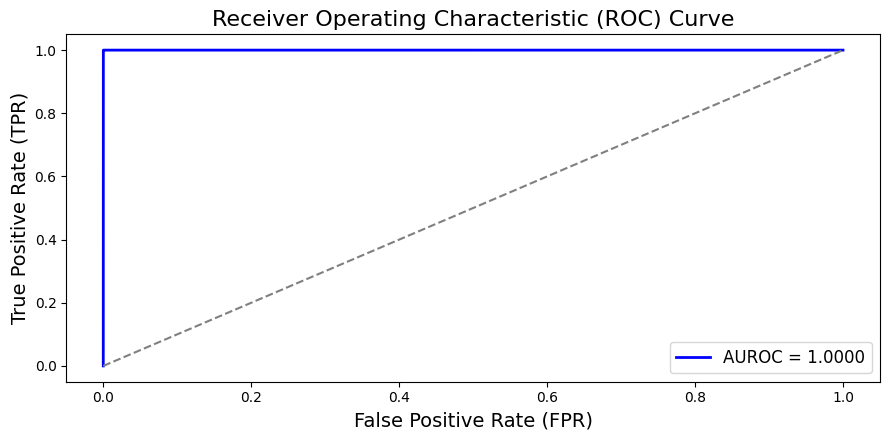

In [18]:
# --------------------------- Best Model Fitting & Evaluation --------------------------- #
# Evaluate the best model on the test set using recall
y_pred = best_model.predict(X_test)  # Get predicted labels
test_recall = recall_score(y_test, y_pred)  # Calculate recall
print("Test Set Recall:", test_recall)

# Get feature names for plotting
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]

# Evaluate the best Random Forest model with all necessary metrics and plots
evaluate_best_model(best_model, X_test, y_test, feature_names)

# **GRADIENT BOOSTING**

In [28]:
# Import Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

# --------------------------- Hyperparameter Tuning --------------------------- #
# Define the Gradient Boosting model
model = GradientBoostingClassifier(random_state=0, max_depth=3)

# Define the parameter grid for Gradient Boosting
param_grid = {
    'n_estimators': [50, 100],  # Number of boosting stages
    'learning_rate': [0.1, 0.2],  # Step size shrinkage
}


# Perform grid search with Stratified k-fold
cv = StratifiedKFold(n_splits=3)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='recall', n_jobs=10, verbose=1)

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Output the best hyperparameters and cross-validated recall score
print("Best Parameters:", best_params)
print("Best Cross-Validated Recall:", grid_search.best_score_)




Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'learning_rate': 0.2, 'n_estimators': 100}
Best Cross-Validated Recall: 0.9999979998059811


Test Set Recall: 1.0
Evaluating the Best Model:


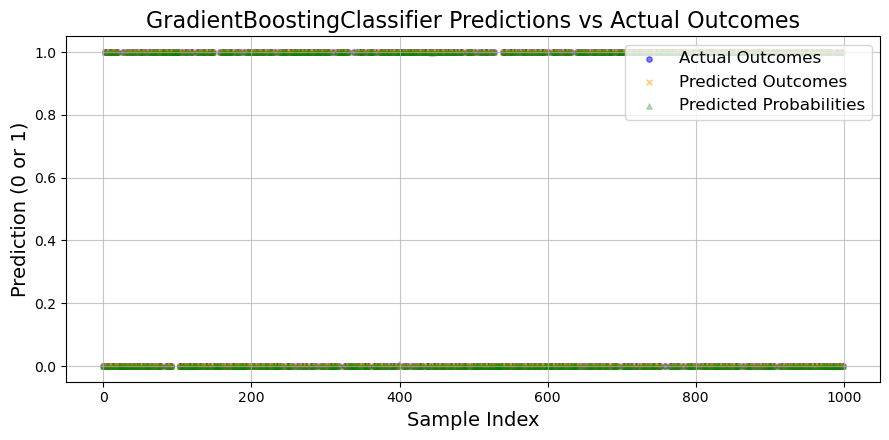

Confusion Matrix:
TN: 249904, FP: 0, FN: 0, TP: 250096


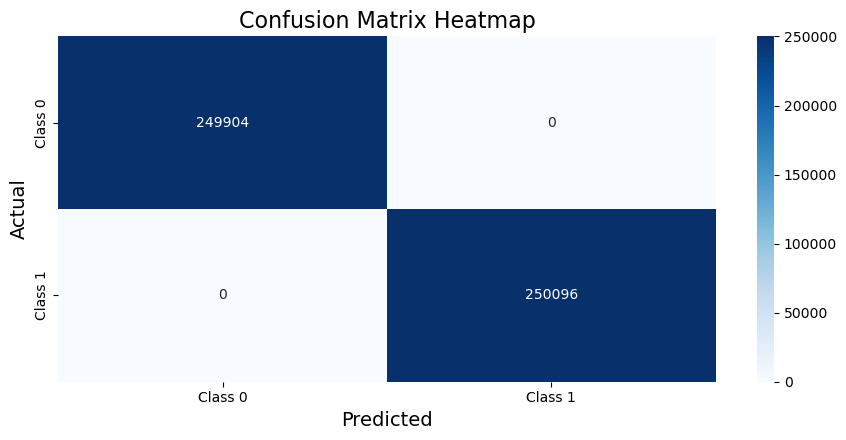


Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00    249904
     Class 1       1.00      1.00      1.00    250096

    accuracy                           1.00    500000
   macro avg       1.00      1.00      1.00    500000
weighted avg       1.00      1.00      1.00    500000



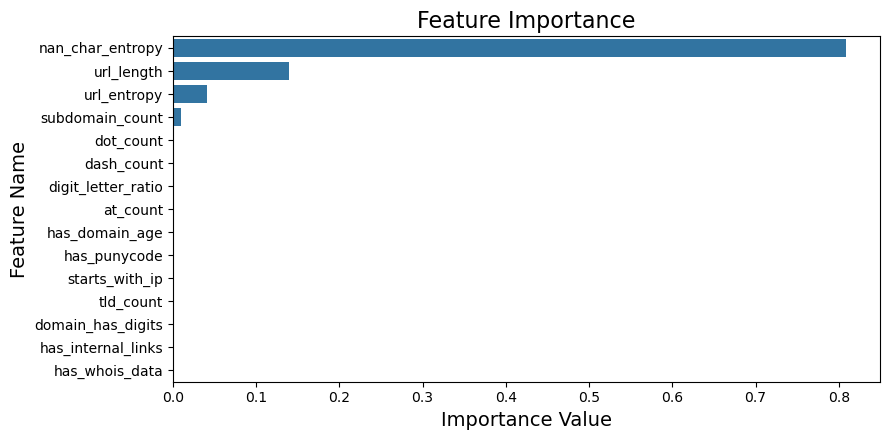


Top Features by Importance:
               Feature    Importance
11    nan_char_entropy  8.091389e-01
0           url_length  1.396565e-01
2          url_entropy  4.074708e-02
10     subdomain_count  1.001839e-02
5            dot_count  3.583643e-04
7           dash_count  4.387976e-05
4   digit_letter_ratio  1.754183e-05
6             at_count  1.673981e-05
13      has_domain_age  2.108364e-06
3         has_punycode  5.512643e-07


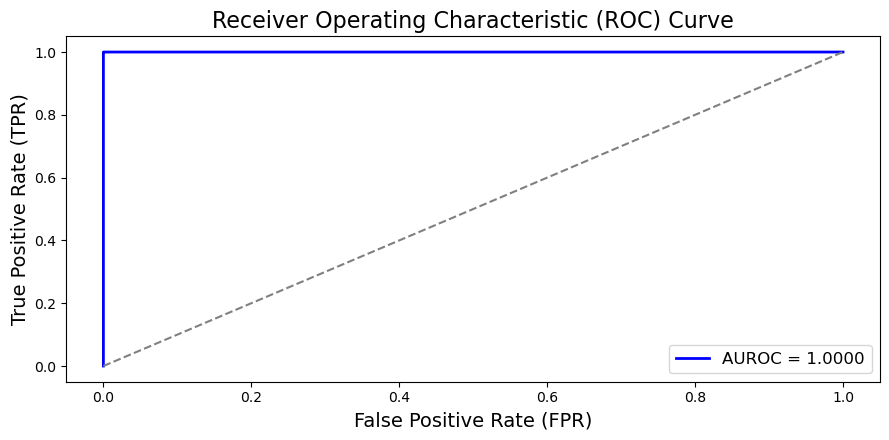

In [29]:
# --------------------------- Best Model Fitting & Evaluation --------------------------- #
# Evaluate the best model on the test set using recall
y_pred = best_model.predict(X_test)  # Get predicted labels
test_recall = recall_score(y_test, y_pred)  # Calculate recall
print("Test Set Recall:", test_recall)

# Get feature names for plotting
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]

# Evaluate the best Gradient Boosting model with all necessary metrics and plots
evaluate_best_model(best_model, X_test, y_test, feature_names)

# **SUPPORT VECTOR MACHINE (SVM)**

In [14]:
# Import Support Vector Machine Classifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# --------------------------- Hyperparameter Tuning --------------------------- #
# Define the SVM model pipeline (with scaling)
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling is important for SVM
    ('svm', SVC(probability=True, random_state=0))
])

# Define the parameter grid for SVM
param_grid = {
    'svm__C': [1],  # Use a single value for faster execution
    'svm__gamma': [0.1],  # Fixed gamma
    'svm__kernel': ['rbf'],  # Fixed kernel
}


# Use Stratified K-Fold for cross-validation
cv = StratifiedKFold(n_splits=2)

# Perform Grid Search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='recall',
    n_jobs=10,
    verbose=1
)

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Cross-Validated Recall:", grid_search.best_score_)



Fitting 2 folds for each of 1 candidates, totalling 2 fits


KeyboardInterrupt: 

In [ ]:
# --------------------------- Evaluation on Test Data --------------------------- #
# Predict on the test set using the best model
y_pred_test = best_model.predict(X_test)

# Calculate recall on the test set
test_recall = recall_score(y_test, y_pred_test)
print("Test Set Recall:", test_recall)

# Evaluate using your utility functions (if available)
print_classification_metrics(y_test, y_pred_test)
plot_auroc_curve(best_model, X_test, y_test)

# **NEURAL NETWORK**

In [21]:
# --------------------------- Hyperparameter Tuning --------------------------- #
# Define the MLP (Multi-layer Perceptron) model
model = MLPClassifier(random_state=0, max_iter=15)
param_grid = {
    'hidden_layer_sizes': [(10,), (20,), (20, 10)],  
    'activation': ['relu'], 
    'solver': ['adam','sgd','lbfgs'],  
    'alpha': [0.0001,0.01],  
    'learning_rate': ['adaptive'],  
}

# Perform grid search with Stratified k-fold
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='recall', n_jobs=-1, verbose=1)

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Output the best hyperparameters and cross-validated recall score
print("Best Parameters:", best_params)
print("Best Cross-Validated Recall:", grid_search.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best Cross-Validated Recall: 0.999996999714973


Test Set Recall: 1.0
Evaluating the Best Model:


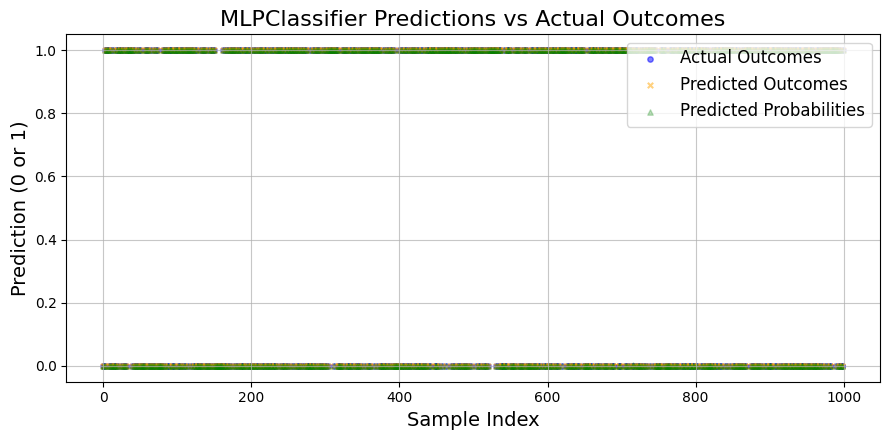

Confusion Matrix:
TN: 249902, FP: 2, FN: 0, TP: 250096


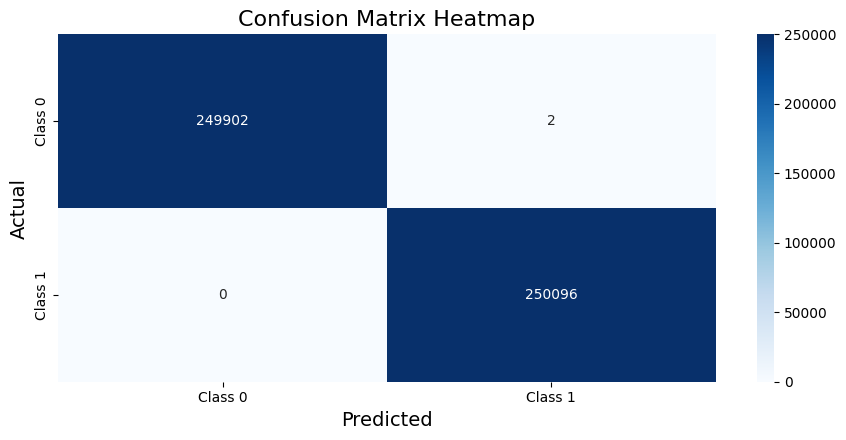


Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00    249904
     Class 1       1.00      1.00      1.00    250096

    accuracy                           1.00    500000
   macro avg       1.00      1.00      1.00    500000
weighted avg       1.00      1.00      1.00    500000



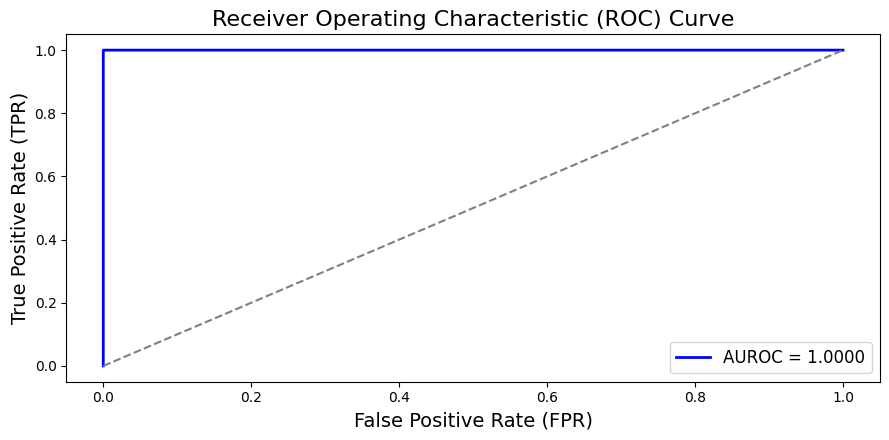

In [22]:
# --------------------------- Best Model Fitting & Evaluation --------------------------- #
# Evaluate the best model on the test set using recall
y_pred = best_model.predict(X_test)  # Get predicted labels
test_recall = recall_score(y_test, y_pred)  # Calculate recall
print("Test Set Recall:", test_recall)

# Get feature names for plotting
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]

# Evaluate the best Random Forest model with all necessary metrics and plots
evaluate_best_model(best_model, X_test, y_test, feature_names)